# Sequential Contracts

This example explores the creation and composition of static contracts using a wiring diagram.

In [1]:
# Activate the require environment
using Pkg
    # Use path relative to notebook
Pkg.activate("../../AlgebraicContracts.jl")

  Activating project at `~/Desktop/Categorical_Semantics/AlgebraicContracts.jl`


In [2]:
using AlgebraicContracts.StaticContracts

In [3]:
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using IntervalSets 

### 1. Contract of a box:
Boxes connected by wires inhabit a wiring diagram. Each box has a single contract for each wire entering and exiting the box in its isolated state. Pairs of intervals form the contracts. 

Box1: C<sub>1</sub> → _Xin_ x _Xout_  
Box2: C<sub>2</sub> → _Yin_ x _Yout_  

We create a _StaticContract_ by specifying the _type_ of variable going through a box and assigning intervals of acceptable values to the inputs and outputs. Each interval is associated with a scalar value sent via a wire. 

For example, let us create a _StaticContract_ for a single box. We assign the intervals Xin = (1,2] at its input, and Xout = [2.0,∞) at its output. The intervals are created using the [IntervalSets](https://juliapackages.com/p/intervalsets) package through the double period operator. 

In [4]:
box1 = StaticContract{Float64}( [ Interval{:open, :closed}(1..2) ], [2..Inf] )

StaticContract( (1,2] × [2.0,∞) )

Let us create a static contract for a second box. We assign unrestricted intervals at its input and output: Yin = Yout = (-∞, ∞) 

In [5]:
box2 = StaticContract{Float64}( [-Inf..Inf], [-Inf..Inf] )

StaticContract( ℝ × ℝ )

### Serial composition:
Consider the case of two boxes connected to each in series. In this configuration, the output of one box is connected to the input of the other box. This results in the following composition:  

C<sub>Series</sub> &rarr; C1 X C2 &rarr; (_Xin_ x _Xout_) x (_Yin_ x _Yout_) &rarr; _Xin_ x _Yout_

This system has a wire that enters the first box, a wire that connects the two boxes, and a wire that exits the second box. Therefore, the net system will have two inputs and one output. Our wiring diagram must reflect these connections.

In [6]:
system = WiringDiagram([:x], [:z]);

The boxes are constructed with arrays of symbols that define their inputs and outputs. Our simple boxes only have a single input and output, so the arrays will only have one element. Moreover, since the boxes have a connection, the _input port_ of box2 must have the same _name_ as the _output port_ of a box2. 

In [7]:
xbox = add_box!(system, Box(:box1, [:x], [:y]))
ybox = add_box!(system, Box(:box2, [:y], [:z]))

2

Wires are added to the diagram through a _box id_ and a _port_ number. Box ids are assigned in the order that boxes are added to the diagram. In this case, _box1_ has id=1, while _box2_ has id=2. The port numbers work in the same way. The input _x_ of _box1_ has port_number=1, while the output _y_ has port_number=1.

Each wire is constructed using a _source_ box with an _output_ port and a _target_ box with an _input_ port. 
Wires go from the output port of a source box to the input port of a target box. For more information on constructing wiring diagrams, see the documentation for [Catlab](https://algebraicjulia.github.io/Catlab.jl/dev/generated/wiring_diagrams/wiring_diagram_basics/). 

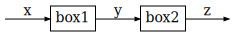

In [8]:
add_wires!(system, [  
  (input_id(system),1) => (xbox,1),  
  (xbox,1) => (ybox,1),
  (ybox,1) => (output_id(system),1)
])

to_graphviz(system, orientation=LeftToRight, labels=true)

We assign static contracts to the wiring diagram through the _oapply_ function. The contracts must be provided in the same order the boxes were added. In our case, we placed _box1_ as the first element of our array as _x_ was the first box to be added. Notice that the resulting contract only considers the wires entering and exiting the _system_.

In [9]:
oapply(system, [box1, box2])

StaticContract( (1,2] × ℝ )

### Parallel Composition:
The boxes are combined to form a larger system with additional inputs and outputs in this configuration. The resulting composition is:

C<sub>Parallel</sub> &rarr; C1 X C2 &rarr; (_Xin_ x _Xout_) x (_Yin_ x _Yout_) &rarr; (_Xin_ x _Yin_) x (_Xout_ x _Yout_)

Given that the boxes are not interconnected, the net system will have two inputs and two outputs. The _name_ of the _ports_ entering and exiting the system _must_ match the name of the _ports_ they connect to. We also include the additional inputs and outputs by adding more elements to the symbol arrays.

In [10]:
system = WiringDiagram([:x, :w], [:y, :z]);

Boxes and wires are added to the diagram like in the serial connection. Boxes are given inputs and outputs, and wires require a source and a target.

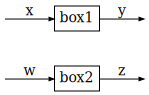

In [11]:
xbox = add_box!(system, Box(:box1, [:x], [:y]))
ybox = add_box!(system, Box(:box2, [:w], [:z]))

add_wires!(system, [  
  (input_id(system),1) => (xbox,1), 
  (input_id(system),2) => (ybox,1),
  (xbox,1) => (output_id(system),1),
  (ybox,1) => (output_id(system),2)
])

to_graphviz(system, orientation=LeftToRight, labels=true)

Like before, we compose the boxes using the _oapply_ function. Notice how the resulting system has more inputs and outputs than the serial composition. These ports represent the greater number of wires entering and exiting the system.

In [12]:
oapply(system, [box1, box2])

StaticContract( (1,2] × ℝ × [2.0,∞) × ℝ )

### 2. Composite contract from autonomy talks
Let us create a more complicated system using the example shown at __23:05__ of [Autonomy Talks: Compositional Cyber-Physical Systems Theory](https://www.youtube.com/watch?v=Ot9szu3HZ8g). The system consists of two boxes connected to a third box. The first two boxes have a single input and output, while the third box receives three inputs and outputs a single value. 

In [13]:
system = WiringDiagram([:g, :c, :a], [:h])

xbox = add_box!(system, Box(:X, [:a], [:b]))
ybox = add_box!(system, Box(:Y, [:c], [:d]))
zbox = add_box!(system, Box(:Z, [:b, :d, :g], [:h]))

3

We assign connections to the system while ensuring the name of a wire at a source matches box the name of the wire at a target box. Notice how the output of the _add_box!_ function is the id of a new box.  

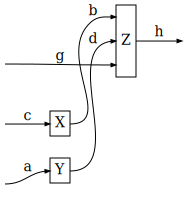

In [14]:
add_wires!(system, [   
    (xbox,1) => (zbox,1),
    (ybox,1) => (zbox,2),
    (zbox,1) => (output_id(system),1),
    (input_id(system),2) => (xbox,1), 
    (input_id(system),3) => (ybox,1), 
    (input_id(system),1) => (zbox,3),   
])

to_graphviz(system, orientation=LeftToRight, labels=true)

We now assign contracts to each of the boxes. Given the third box has three inputs, we must define three intervals for its inputs. Likewise, as there is only one output per box, the resulting arrays only have a single element. Let our boxes have the following contracts:  

C<sub>x</sub> &rarr; [4,5] x [4,5]  
C<sub>y</sub> &rarr; [8,9] x [8,9]  
C<sub>z</sub> &rarr; ( [3,5] x [7,9] x (-∞,∞) ) x [0,1]  

In [15]:
# Contracts for each box
rx = StaticContract{Float64}( [4..5], [4..5] )
ry = StaticContract{Float64}( [8..9], [8..9] )
rz = StaticContract{Float64}( [3..5, 7..9, -Inf..Inf], [0..1] )

StaticContract( [3.0,5.0] × [7.0,9.0] × ℝ × [0,1] )

Next, we compose the contracts using the wiring diagram. Notice how the composition matches the result of the example shown in the video. The new system has three inputs and one output, and the net contract reflects this by showing four intervals.

In [16]:
# Net contract for system
oapply(system, Dict(:X=>rx, :Y=>ry, :Z=>rz)) 

StaticContract( [4,5] × [8,9] × ℝ × [0,1] )

### 3. Composite contracts for a UAV system

Let us construct another system that includes a feedback loop. To do this, we shall use the UAV example from page 22 of [Categorical Semantics of Cyber-Physical Systems Theory](https://arxiv.org/abs/2010.08003). 

Like before, we must construct a wiring diagram for our system. It will consist of a sensor box, a controller box, and a dynamics box. The sensor shall receive an external input __e__ and the system's state __s__ and output a measured state __s_prime__. The controller shall receive the measured signal __s_prime__, target state __d__, and output a control signal __c__. Finally, the dynamics box shall receive the control input __c__ and output the system's state __s__. 

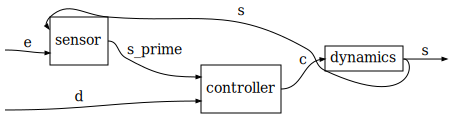

In [17]:
# Create the net system, two inputs, one output
UAV = WiringDiagram([:e,:d], [:s])

# Boxes have the inputs and outputs mentioned in the description
sensor     = add_box!(UAV, Box(:sensor    , [:s, :e]      , [:s_prime]))
controller = add_box!(UAV, Box(:controller, [:s_prime, :d], [:c]))
dynamics   = add_box!(UAV, Box(:dynamics  , [:c]          , [:s]))

# Attach wires using box id's and port numbers
add_wires!(UAV, [     
  (input_id(UAV),1) => (sensor,2),
  (input_id(UAV),2) => (controller,2),
  (sensor,1) => (controller,1),
  (controller,1) => (dynamics,1),
  (dynamics,1) => (sensor,1),
  (dynamics,1) => (output_id(UAV),1)
])

# Display the graph
to_graphviz(UAV, orientation=LeftToRight, labels=true)

As we can see from the wiring diagram, the system has a feedback loop between the dynamics box and the controller. However, this detail does not affect how we declare our static contracts. We still assign arrays of intervals to each box. To this end, let us give each box the following contracts:

C<sub>sensor</sub> &rarr; ( (-∞,∞) x [0,100] ) x (-∞,∞)   
C<sub>machine</sub> &rarr; ( (-∞,∞) x [-20,20] ) x (-∞,∞)  
C<sub>dynamics</sub> &rarr; (-∞,∞) x [-35,35]  

Notice how the order of the intervals in the contracts coincides with the port of a box. For example, __e__ has the restriction [0,100] at the sensor box. 

In [18]:
# Define the contracts for each box
s_machine = StaticContract{Float64}([-Inf..Inf,  0.0..100.0],  # Inputs   
                                    [-Inf..Inf])               # Outputs

c_machine = StaticContract{Float64}([-Inf..Inf,  -20.0..20.0], # Inputs
                                    [-Inf..Inf])               # Outputs     
 
d_machine = StaticContract{Float64}([-Inf..Inf],               # Inputs
                                    [-35.0..35.0])             # Outputs

StaticContract( ℝ × [-35.0,35.0] )

Finally, we compose the contracts using the wiring diagram by assigning contracts to each box. We may do this with a dictionary by referencing the box's name we want to populate. Additionally, since we have two inputs and one output, the combined system will display three intervals.  

In [19]:
# compose system
comp = oapply(UAV, Dict(:sensor => s_machine, 
                        :controller => c_machine, 
                        :dynamics => d_machine))

StaticContract( [0.0,100.0] × [-20.0,20.0] × [-35.0,35.0] )